In [1]:
import pandas as pd
import numpy as np
import pickle
import yaml
import boto3

## 1. Load the clean data from step 3 and stored in the S3 bucket. 

Use a function load_data_s3 that receives as parameters the S3 bucket and the path where the file with the clean inspection data saved at the end of step 3 is located.  

To know which file to download, use the list_objects_v2 function of boto3 and identify the name of the stored pkl.

In [5]:
with open('credentials.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

bucket = 'aplicaciones-cd-1-' + config['iexe']['matricula']

session = boto3.Session(
        aws_access_key_id = config['s3']['aws_access_key_id'],
        aws_secret_access_key = config['s3']['aws_secret_access_key'],
        aws_session_token = config['s3']['aws_session_token']
    )    
s3 = session.client('s3')
key = s3.list_objects_v2(Bucket=bucket, Prefix="ingesta/inicial/")['Contents'][0]['Key']
print(key)


ingesta/inicial/datos-limpios-2023-07-09.pkl


In [6]:
def cargar_datos_s3(bucket):

    session = boto3.Session(
        aws_access_key_id = config['s3']['aws_access_key_id'],
        aws_secret_access_key = config['s3']['aws_secret_access_key'],
        aws_session_token = config['s3']['aws_session_token']
    )    
    s3 = session.resource('s3')
    obj = s3.Object(bucket, key).get()['Body'].read()
    return obj    


In [7]:
def transformar_ingesta(obj):
    df_load = pickle.loads(obj)
    return df_load

In [8]:
bucket = 'aplicaciones-cd-1-' + config['iexe']['matricula']
obj = cargar_datos_s3(bucket)
df = transformar_ingesta(obj)
df = pd.DataFrame(df)

In [9]:
df.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,latitude,longitude,location,violations
0,67732,WOLCOTT'S,TROQUET,1992039,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN
1,67757,DUNKIN DONUTS/BASKIN-ROBBINS,DUNKIN DONUTS/BASKIN-ROBBINS,1380279,Restaurant,Risk 2 (Medium),100 W RANDOLPH ST,CHICAGO,IL,60601,2010-01-04,Tag Removal,Pass,41.884586,-87.631010,"{'latitude': '41.88458626715456', 'longitude':...",NaN
2,52234,Cafe 608,Cafe 608,2013328,Restaurant,Risk 1 (High),608 W BARRY AVE,CHICAGO,IL,60657,2010-01-04,License Re-Inspection,Pass,41.938007,-87.644755,"{'latitude': '41.938006880423615', 'longitude'...",NaN
3,70269,mr.daniel's,mr.daniel's,1899292,Restaurant,Risk 1 (High),5645 W BELMONT AVE,CHICAGO,IL,60634,2010-01-04,License Re-Inspection,Pass,41.938443,-87.768318,"{'latitude': '41.93844282365204', 'longitude':...",NaN
5,104236,TEMPO CAFE,TEMPO CAFE,80916,Restaurant,Risk 1 (High),6 E CHESTNUT ST,CHICAGO,IL,60611,2010-01-04,Canvass,Fail,41.898431,-87.628009,"{'latitude': '41.89843137207629', 'longitude':...",18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...


## 2. Create a function delete_inspections() 
function to delete the observations of inspections that have as inspection result any of the following values: Business Not Located, No Entry, Out of Business. This function receives as input the data frame that contains all the clean observations that were loaded in point 1. The output of this function is a data frame that no longer includes the observations that have this result. 

How many inspection records are there now?

In [3]:
print(f'El dataset inicial tiene {df.shape[0]} registros')

El dataset inicial tiene 260183 registros


In [4]:
df.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2478
license_               0
facility_type          0
risk                   0
address                0
city                 184
state                 58
zip                    0
inspection_date        0
inspection_type        1
results                0
latitude               0
longitude              0
location               0
violations         71037
dtype: int64

In [11]:
resultados = df['results'].value_counts().to_frame()

In [6]:
resultados.reset_index(inplace=True)

In [7]:
resultados

,index,results
0,Pass,133885
1,Fail,50799
2,Pass w/ Conditions,39883
3,Out of Business,22050
4,No Entry,10237
5,Not Ready,3248
6,Business Not Located,81


In [8]:
def delete_inspections(df, lista):
    for resultado in lista:
        df = df[df['results'] != resultado]
    return df


In [9]:
lista = ['Business Not Located', 'No Entry', 'Out of Business']
resultados[resultados['index'].isin(lista)]

,index,results
3,Out of Business,22050
4,No Entry,10237
6,Business Not Located,81


In [10]:
resultados[resultados['index'].isin(lista)]['results'].sum()

32368

In [11]:
df = delete_inspections(df, lista)

In [12]:
df['results'].value_counts()

Pass                  133885
Fail                   50799
Pass w/ Conditions     39883
Not Ready               3248
Name: results, dtype: int64

In [13]:
print(f'El nuevo dataset tiene {df.shape[0]} registros')

El nuevo dataset tiene 227815 registros


## 3. Create a function transform_result() 
that will help transform the results variable so that only the values fail and pass exist. The observations with results Pass, Pass w/ Conditions will have to have the value pass, while the rest of the values will have to have the value fail.

This function receives as input the data frame obtained from step 2, and has as output the data frame with the result changed to pass or fail.

How many inspection records have pass and how many fail?

In [14]:
resultados2 = df['results'].value_counts().to_frame()

In [15]:
resultados2.reset_index(inplace=True)

In [16]:
resultados2

,index,results
0,Pass,133885
1,Fail,50799
2,Pass w/ Conditions,39883
3,Not Ready,3248


In [18]:
def transform_result(df):
    dicc = {'Pass w/ Conditions' : 'Pass', 'Not Ready': 'Fail'}
    df['results'] = df['results'].replace(dicc)
    return df

In [19]:
df = transform_result(df)

In [20]:
df['results'].value_counts()

Pass    173768
Fail     54047
Name: results, dtype: int64

In [21]:
registros = list(df['results'].value_counts().values)

In [22]:
print(f'Cantidad de registros de Pass: {registros[0]} \nCantidad de registros de Fail: {registros[1]}')

Cantidad de registros de Pass: 173768 
Cantidad de registros de Fail: 54047


## 4. Create the function transform_risk() 
which will help transform the risk variable so that Risk 1 (High) becomes high, Risk 2 (Medium) becomes medium and Risk 3 (Low) becomes low, and All becomes all.

In [23]:
df['risk'].value_counts()

Risk 1 (High)      169789
Risk 2 (Medium)     42256
Risk 3 (Low)        15738
All                    32
Name: risk, dtype: int64

In [24]:
risk_dict = {'Risk 1 (High)': 'high','Risk 2 (Medium)': 'medium', 'Risk 3 (Low)': 'low', \
             'All': 'all'}
def transform_risk(df):
    df['risk'].replace(risk_dict, inplace=True)
    return df

In [25]:
df = transform_risk(df)

In [26]:
df['risk'].value_counts()

high      169789
medium     42256
low        15738
all           32
Name: risk, dtype: int64

## 5. Create the function transform_facility() 
which will help transform the facility_type variable to have the following values:

● All facility_type containing the word Daycare should be changed to daycare.

● All facility_type containing the word Restaurant should be changed to restaurant.

All facility_types containing the words Mobile Food should be changed to mobile food.

Once these types are modified, get the top 20 facility_type with the most records, the rest of the facilty_type change them to other in a transform_facility_other() function.

In [27]:
df.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,latitude,longitude,location,violations
0,52234,Cafe 608,Cafe 608,2013328,Restaurant,high,608 W BARRY AVE,CHICAGO,IL,60657,2010-01-04,License Re-Inspection,Pass,41.938007,-87.644755,"{'latitude': '41.938006880423615', 'longitude'...",NaN
1,67757,DUNKIN DONUTS/BASKIN-ROBBINS,DUNKIN DONUTS/BASKIN-ROBBINS,1380279,Restaurant,medium,100 W RANDOLPH ST,CHICAGO,IL,60601,2010-01-04,Tag Removal,Pass,41.884586,-87.631010,"{'latitude': '41.88458626715456', 'longitude':...",NaN
3,67732,WOLCOTT'S,TROQUET,1992039,Restaurant,high,1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN
4,104236,TEMPO CAFE,TEMPO CAFE,80916,Restaurant,high,6 E CHESTNUT ST,CHICAGO,IL,60611,2010-01-04,Canvass,Fail,41.898431,-87.628009,"{'latitude': '41.89843137207629', 'longitude':...",18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
5,67733,WOLCOTT'S,TROQUET,1992040,Restaurant,high,1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN


In [28]:
df['facility_type'].unique()

array(['Restaurant', 'RIVERWALK CAFE', 'Grocery Store',
       'GAS STATION/RESTAURANT', 'School', 'Daycare (2 - 6 Years)',
       'Daycare Above and Under 2 Years', 'Catering', 'Bakery',
       'ICE CREAM SHOP', 'GROCERY& RESTAURANT', 'GAS STATION',
       "Children's Services Facility", 'Daycare Combo 1586', 'Liquor',
       'Hospital', 'Daycare (Under 2 Years)', 'Mobile Food Dispenser',
       'Wholesale', 'Shelter', 'Golden Diner', 'TAVERN', 'NURSING HOME',
       'JUICE AND SALAD BAR', "Kids Cafe'", 'Long Term Care',
       'DAYCARE 2-6, UNDER 6', 'MOBILE FOOD', 'LIVE POULTRY',
       'AFTER SCHOOL PROGRAM', 'convenience', 'Daycare (2 Years)',
       'WHOLESALE BAKERY', 'Candy', 'Shared Kitchen', 'Deli',
       'coffee shop', 'incubator', 'RESTAURANT/BAR',
       'SLAUGHTER HOUSE/ GROCERY', 'GAS STATION/MINI MART', 'theater',
       'donut shop', 'COLLEGE', 'GROCERY/CAFE', 'TAVERN/LIQUOR',
       'Special Event', 'ASSISTED LIVING', 'GAS STATION/ GROCERY STORE',
       'Long-Term C

In [29]:
def transform_facility(df):
    import re
    facility_dic = {elemento:elemento for elemento in list(df['facility_type'].unique())}
    for key, value in facility_dic.items():    
        x1,x2,x3 = re.search(r'.*Daycare.*', value),re.search(r'.*Restaurant.*', value),re.search(r'.*Mobile Food.*', value)
        if x1: 
            facility_dic[key] = 'daycare'
        if x2: 
            facility_dic[key] = 'restaurant'
        if x3: 
            facility_dic[key] = 'mobile food'    
    df['facility_type'].replace(facility_dic, inplace=True)
    return df
        

In [30]:
df = transform_facility(df)

In [31]:
df['facility_type'][30:60]

31       restaurant
32       restaurant
33    Grocery Store
34    Grocery Store
35           School
36       restaurant
37          daycare
38    Grocery Store
39       restaurant
40       restaurant
41    Grocery Store
42    Grocery Store
43          daycare
44       restaurant
45    Grocery Store
46    Grocery Store
47       restaurant
48    Grocery Store
49    Grocery Store
50          daycare
51       restaurant
52    Grocery Store
53          daycare
54          daycare
55       restaurant
56       restaurant
57       restaurant
58       restaurant
59          daycare
60       restaurant
Name: facility_type, dtype: object

In [33]:
df.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,latitude,longitude,location,violations
0,52234,Cafe 608,Cafe 608,2013328,restaurant,high,608 W BARRY AVE,CHICAGO,IL,60657,2010-01-04,License Re-Inspection,Pass,41.938007,-87.644755,"{'latitude': '41.938006880423615', 'longitude'...",NaN
1,67757,DUNKIN DONUTS/BASKIN-ROBBINS,DUNKIN DONUTS/BASKIN-ROBBINS,1380279,restaurant,medium,100 W RANDOLPH ST,CHICAGO,IL,60601,2010-01-04,Tag Removal,Pass,41.884586,-87.631010,"{'latitude': '41.88458626715456', 'longitude':...",NaN
3,67732,WOLCOTT'S,TROQUET,1992039,restaurant,high,1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN
4,104236,TEMPO CAFE,TEMPO CAFE,80916,restaurant,high,6 E CHESTNUT ST,CHICAGO,IL,60611,2010-01-04,Canvass,Fail,41.898431,-87.628009,"{'latitude': '41.89843137207629', 'longitude':...",18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
5,67733,WOLCOTT'S,TROQUET,1992040,restaurant,high,1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN


In [32]:
def transform_facility_other(df):
    top_20_facility_type = list(df.groupby('facility_type')['facility_type'].count().\
                            sort_values(ascending = False).head(20).index)
    print(top_20_facility_type)
    facility_dic = {elemento:elemento for elemento in list(df['facility_type'].unique())}
    for key, value in facility_dic.items():    
        if key not in top_20_facility_type:
            facility_dic[key] = 'other'
    df['facility_type'].replace(facility_dic, inplace=True)
    return df



In [33]:
df = transform_facility_other(df)

['restaurant', 'Grocery Store', 'School', 'daycare', "Children's Services Facility", 'Bakery', 'Long Term Care', 'mobile food', 'Catering', 'Liquor', 'Hospital', 'Golden Diner', 'Wholesale', 'TAVERN', 'Shared Kitchen User (Long Term)', 'Special Event', 'Shared Kitchen', 'GAS STATION', 'BANQUET HALL', 'Shelter']


In [34]:
df['facility_type'].value_counts()

restaurant                         154862
Grocery Store                       28960
School                              15679
daycare                              6861
Children's Services Facility         5047
other                                3921
Bakery                               3332
Long Term Care                       1799
mobile food                          1610
Catering                             1322
Liquor                               1010
Hospital                              723
Golden Diner                          682
Wholesale                             515
TAVERN                                342
Shared Kitchen User (Long Term)       267
Special Event                         265
Shared Kitchen                        197
GAS STATION                           177
BANQUET HALL                          123
Shelter                               121
Name: facility_type, dtype: int64

## 6. Create the function generate_features() which will generate the following features: 

a. month: Obtained from the inspection_date variable.  

b. year: Obtained from the variable inspection_date

c. day_of_month: Obtained from the variable inspection_date

d. week_of_year: Retrieved from the inspection_date variable

e. week_day: Retrieved from the inspection_date variable. This variable indicates whether the day of the week is a "weekday": Monday, Tuesday, Wednesday, Thursday or Friday. If it is a weekday, its value is 1, otherwise 0.

f. weekend: Obtained from the inspection_date variable. This variable indicates whether the day of the week is "weekend": Saturday or Sunday. If it is a weekend, its value is 1, 0 otherwise.

g. day_of_week: Obtained from the inspection_date variable.


This function receives as input the data frame obtained in step 3. The output is a data frame that includes these new variables.

In [35]:
def generate_features(df):
    df['month'] = pd.DatetimeIndex(df['inspection_date']).month
    df['year'] = pd.DatetimeIndex(df['inspection_date']).year
    df['day_of_month'] = pd.DatetimeIndex(df['inspection_date']).day
    df['week_of_year'] = df['inspection_date'].dt.isocalendar().week
    weekday = list(pd.DatetimeIndex(df['inspection_date']).dayofweek)
    weekday = [1 if i in range(0,5) else 0 for i in weekday]
    df['week_day'] = weekday
    weekend = list(pd.DatetimeIndex(df['inspection_date']).dayofweek)
    weekend = [1 if i not in range(0,5) else 0 for i in weekend]
    df['weekend'] = weekend
    df['day_of_week'] = pd.DatetimeIndex(df['inspection_date']).dayofweek
    return df

In [36]:
df = generate_features(df)

In [37]:
df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'latitude', 'longitude', 'location',
       'violations', 'month', 'year', 'day_of_month', 'week_of_year',
       'week_day', 'weekend', 'day_of_week'],
      dtype='object')

In [38]:
df[['inspection_id','inspection_date', 'week_day', 'month', 'year', 'day_of_month', 'week_of_year', 'weekend', 'day_of_week', 'results']]

,inspection_id,inspection_date,week_day,month,year,day_of_month,week_of_year,weekend,day_of_week,results
0,52234,2010-01-04,1,1,2010,4,1,0,0,Pass
1,67757,2010-01-04,1,1,2010,4,1,0,0,Pass
3,67732,2010-01-04,1,1,2010,4,1,0,0,Pass
4,104236,2010-01-04,1,1,2010,4,1,0,0,Fail
5,67733,2010-01-04,1,1,2010,4,1,0,0,Pass
...,...,...,...,...,...,...,...,...,...,...
261075,2582976,2023-10-06,1,10,2023,6,40,0,4,Fail
261076,2582972,2023-10-06,1,10,2023,6,40,0,4,Pass
261077,2583002,2023-10-06,1,10,2023,6,40,0,4,Pass
261078,2582968,2023-10-06,1,10,2023,6,40,0,4,Pass


## 7. Create the feature_matrix() function that will generate the design matrix. 
This function should occupy sklearn's ColumnTransformer method through which to perform the following transformations: 

● Modify the risk column to become one hot encoding.

● Modify the restaurant column to convert it to one hot encoding.

● Pass the columns generated in step 6.

Create an auxiliary data frame containing only the variables facility_type, risk, latitude, longitude and the columns generated in step 6. Once this data frame is created, send it to the feature_matrix function to occupy the ColumnTransformer.

The output of this function is the data frame that will be used in the modeling section.

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [41]:
def feature_matrix(df_a_transformar, vbles_a_transformar, cols):
    transformers = [('one_hot_cols', OneHotEncoder(), vbles_a_transformar)]
    col_transformed = ColumnTransformer(transformers, remainder='passthrough', 
                                        n_jobs=-1, verbose = True)
    col_transformed.fit(df_a_transformar)
    transformed_cols = col_transformed.transform(df_a_transformar)
    design_matrix = pd.DataFrame(transformed_cols, columns=cols)
    return design_matrix

In [42]:
variables = ['risk', 'facility_type','latitude', 'longitude','week_day', \
            'month', 'year', 'day_of_month', 'week_of_year', 'weekend', 'day_of_week', 'results', \
            'inspection_id','inspection_date']
df_a_transformar = df[variables]
vbles_a_transformar = ['risk', 'facility_type']

#get the name of the columns that are to be transformed in their one hot enconding form as well as the ones
#that were not transformed:
OH_risk = list(df['risk'].value_counts().sort_index().index)
OH_facility_type = list(df['facility_type'].value_counts().sort_index().index)
columnas_no_transformadas = [i for i in variables if i not in vbles_a_transformar]
cols = OH_risk + OH_facility_type + columnas_no_transformadas

design_matrix = feature_matrix(df_a_transformar, vbles_a_transformar, cols)


In [43]:
pd.set_option('display.max_columns', None)

In [44]:
design_matrix.head()

,all,high,low,medium,BANQUET HALL,Bakery,Catering,Children's Services Facility,GAS STATION,Golden Diner,Grocery Store,Hospital,Liquor,Long Term Care,School,Shared Kitchen,Shared Kitchen User (Long Term),Shelter,Special Event,TAVERN,Wholesale,daycare,mobile food,other,restaurant,latitude,longitude,week_day,month,year,day_of_month,week_of_year,weekend,day_of_week,results,inspection_id,inspection_date
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,41.938007,-87.644755,1,1,2010,4,1,0,0,Pass,52234,2010-01-04
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,41.884586,-87.63101,1,1,2010,4,1,0,0,Pass,67757,2010-01-04
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,41.961606,-87.675967,1,1,2010,4,1,0,0,Pass,67732,2010-01-04
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,41.898431,-87.628009,1,1,2010,4,1,0,0,Fail,104236,2010-01-04
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,41.961606,-87.675967,1,1,2010,4,1,0,0,Pass,67733,2010-01-04


In [50]:
df.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,latitude,longitude,location,violations,month,year,day_of_month,week_of_year,week_day,weekend,day_of_week
0,67732,WOLCOTT'S,TROQUET,1992039,restaurant,high,1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN,1,2010,4,1,1,0,0
1,67757,DUNKIN DONUTS/BASKIN-ROBBINS,DUNKIN DONUTS/BASKIN-ROBBINS,1380279,restaurant,medium,100 W RANDOLPH ST,CHICAGO,IL,60601,2010-01-04,Tag Removal,Pass,41.884586,-87.631010,"{'latitude': '41.88458626715456', 'longitude':...",NaN,1,2010,4,1,1,0,0
2,52234,Cafe 608,Cafe 608,2013328,restaurant,high,608 W BARRY AVE,CHICAGO,IL,60657,2010-01-04,License Re-Inspection,Pass,41.938007,-87.644755,"{'latitude': '41.938006880423615', 'longitude'...",NaN,1,2010,4,1,1,0,0
3,70269,mr.daniel's,mr.daniel's,1899292,restaurant,high,5645 W BELMONT AVE,CHICAGO,IL,60634,2010-01-04,License Re-Inspection,Pass,41.938443,-87.768318,"{'latitude': '41.93844282365204', 'longitude':...",NaN,1,2010,4,1,1,0,0
5,104236,TEMPO CAFE,TEMPO CAFE,80916,restaurant,high,6 E CHESTNUT ST,CHICAGO,IL,60611,2010-01-04,Canvass,Fail,41.898431,-87.628009,"{'latitude': '41.89843137207629', 'longitude':...",18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,1,2010,4,1,1,0,0


## 8. Create the function save_feature_matrix() 
which will save in the bucket applications-cd-1 in the path feature-matrix/feature-matrix-YYYYY-MM-DD.pkl, a pickle of the design matrix. 

The suffix of the files stored in the bucket must carry the date of the day on which the design matrix was created, it must be obtained dynamically through the today function of the datetime.time package.

In [45]:
from datetime import date
TODAY = date.today()

In [53]:
def guardar_datos_s3(bucket, key, matriz):    
    session = boto3.Session(
        aws_access_key_id = config['s3']['aws_access_key_id'],
        aws_secret_access_key = config['s3']['aws_secret_access_key'],
        aws_session_token = config['s3']['aws_session_token']
    )
    s3 = session.resource('s3')
    s3.Object(bucket, key).put(Body = matriz)

In [55]:
TODAY

datetime.date(2023, 7, 16)

In [56]:
feature_matrix_ = pickle.dumps(design_matrix)
filename = "feature-matrix" + str(TODAY) + '.pkl'

bucket = 'aplicaciones-cd-1-' + config['iexe']['matricula']
key = "feature-matrix/" + filename

guardar_datos_s3(bucket, key, feature_matrix_)

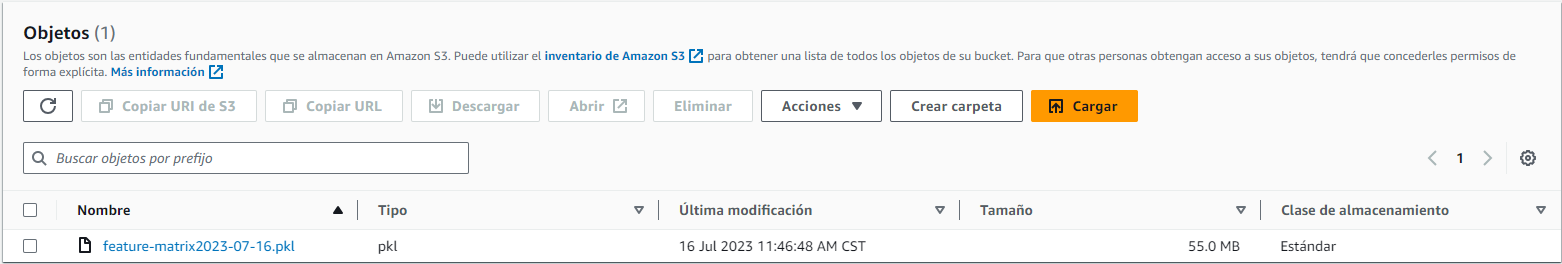

In [47]:
label = df['results']
label.head()

0    Pass
1    Pass
3    Pass
4    Fail
5    Pass
Name: results, dtype: object

In [48]:
label.shape

(227815,)

In [49]:
design_matrix.shape

(227815, 37)

In [50]:
filename = "label" + str(TODAY) + '.pkl'
pickle.dump(label, open(filename,'wb')) #Guardar el archivo localmente

This concludes the first part of the project, which consisted of an exploratory data analysis, with the corresponding cleaning of null data, atypical data, variable name changes, column transformations, etc., in addition to performing the feature engineering, which is very important to generate the design matrix to carry out the data modeling later on.